In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import datetime
import random
import time

Needed `pip install xlrd` to load Excel spreadsheet.

Data are downloaded from here https://www.acaps.org/covid19-government-measures-dataset on 3/22/20.

# Load and high level summary

In [2]:
path = '../data/'
data_dict = pd.read_excel(path + '20200317_acaps_covid-19_goverment_measures_dataset_0.xlsx', sheet_name=1)
df = pd.read_excel(path + '20200317_acaps_covid-19_goverment_measures_dataset_0.xlsx', sheet_name=2)

In [3]:
data_dict

,Column,Variable Name,Label,Format,Codes,Missing Values,Comments
0,A,ID,ID,Numeric,none,Not allowed,Progressive numbers of entries
1,B,COUNTRY,COUNTRY,Text,none,Not allowed,Manual
2,C,ISO,ISO,Text,iso3 code,Not allowed,Automated VLOOKUP with iso code
3,D,ADMIN_LEVEL,ADMIN_LEVEL,Text,none,Blank,if necessary
4,E,PCODE,PCODE,Text,none,Blank,if necessary
5,F,CATEGORY,CATEGORY,Text,none,Not allowed,Dropdown
6,G,MEASURE_TYPE,MEASURE_TYPE,Text,none,Not allowed,Dropdown
7,H,TARGETED_POP_GROUP,TARGETED_POP_GROUP,Text,none,Not allowed,Dropdown
8,I,COMMENTS,COMMENTS,Text,none,Blank,if necessary
9,J,DATE_IMPLEMENTED,DATE_IMPLEMENTED,Date (DD/MM/YYYY),none,Blank,Manual


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  815 non-null    int64         
 1   COUNTRY             815 non-null    object        
 2   ISO                 815 non-null    object        
 3   ADMIN_LEVEL_NAME    24 non-null     object        
 4   PCODE               0 non-null      float64       
 5   REGION              815 non-null    object        
 6   CATEGORY            815 non-null    object        
 7   MEASURE             815 non-null    object        
 8   TARGETED_POP_GROUP  777 non-null    object        
 9   COMMENTS            694 non-null    object        
 10  DATE_IMPLEMENTED    701 non-null    datetime64[ns]
 11  SOURCE              797 non-null    object        
 12  SOURCE_TYPE         793 non-null    object        
 13  LINK                792 non-null    object        

In [5]:
df.head()

,ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,PCODE,REGION,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
0,1,Afghanistan,AFG,NaN,NaN,Asia,Public health measures,Health screenings in airports and border cross...,No,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
1,2,Afghanistan,AFG,Kabul,NaN,Asia,Public health measures,Introduction of quarantine policies,No,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
2,3,Afghanistan,AFG,NaN,NaN,Asia,Public health measures,Awareness campaigns,No,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
3,4,Afghanistan,AFG,NaN,NaN,Asia,Social and economic measures,Emergency administrative structures activated ...,No,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
4,5,Afghanistan,AFG,NaN,NaN,Asia,Social distancing,Limit public gatherings,No,Nevruz festival cancelled,2020-03-12,AA,Media,https://www.aa.com.tr/en/asia-pacific/coronavi...,2020-03-14,NaN


In [6]:
all_countries = df['COUNTRY'].unique()
all_countries

array(['Afghanistan', 'Bhutan', 'Antigua and Barbuda', 'Bolivia',
       'Bosnia and Herzegovina', 'Argentina', 'Albania', 'Nepal',
       'Algeria', 'Bangladesh', 'Angola', 'Chile', 'Uruguay', 'Paraguay',
       'Peru', 'Azerbaijan', 'Brazil', 'Portugal', 'Ecuador', 'Colombia',
       'Armenia', 'Bahrain', 'Venezuela', 'Guyana', 'Suriname', 'Belgium',
       'Panama', 'Australia', 'Costa Rica', 'Nicaragua', 'Honduras',
       'Belize', 'El Salvador', 'Bahamas', 'Guatemala', 'Benin', 'Mexico',
       'Brunei Darussalam', 'Bulgaria', 'Papua New Guinea',
       'Solomon Islands', 'Cameroon', 'Tuvalu', 'Vanuatu', 'Fiji',
       "Côte d'Ivoire", 'Tonga', 'Nauru', 'Kiribati', 'Indonesia',
       'Senegal', 'Philippines', 'Chad', 'Malaysia', 'Burkina Faso',
       'China', 'Congo DR', 'Barbados', 'Canada', 'Thailand',
       'New Zealand', 'Congo', 'United Kingdom', 'Comoros', 'Madagascar',
       'Cyprus', 'Dominica', 'United States of America', 'Mali',
       'Grenada', 'Saint Lucia', 'Sai

In [7]:
df['COUNTRY'].unique().shape

(186,)

In [8]:
categories = df['CATEGORY'].unique()
categories

array(['Public health measures', 'Social and economic measures',
       'Social distancing', 'Movement restrictions', 'Human rights'],
      dtype=object)

In [9]:
measures = df['MEASURE'].unique()
measures

array(['Health screenings in airports and border crossings',
       'Introduction of quarantine policies', 'Awareness campaigns',
       'Emergency administrative structures activated or established',
       'Limit public gatherings', 'Border closure\xa0',
       'Schools closure\xa0', 'Travel restrictions',
       'Strengthening the public health system', 'Flights suspension',
       'Limit product imports/exports', 'Border checks\xa0',
       'Visa restrictions', 'Checkpoints', 'Economic measures',
       'State of emergency declared',
       'Additional health/documents requirements upon arrival',
       'Public services closure\xa0',
       'Changes in prison-related policies', 'General recommendations',
       'General lockdown',
       'Psychological assistance and medical social work',
       'Obligatory medical tests not related to COVID-19',
       'Screening of all Citizens', 'Electronic surveilance',
       'Lockdown of refugee/idp camps'], dtype=object)

In [10]:
df['MEASURE'].unique().shape

(26,)

# Look at a few specific countries

In [11]:
countries_of_int = ['China', 'Italy', 'United States of America', 'Korea Republic of']

In [12]:
for country in countries_of_int:
    print('====================================')
    print(country)
    country_mask = df['COUNTRY'] == country
    print(df[country_mask]['ID'].count() , 'measures enacted')
    print('earliest' , str(df[country_mask]['DATE_IMPLEMENTED'].min()))
    print('most recent' , str(df[country_mask]['DATE_IMPLEMENTED'].max()))
    print(df[country_mask][['DATE_IMPLEMENTED', 'MEASURE', 'CATEGORY']])
    print('\n')

China
17 measures enacted
earliest 2020-01-20 00:00:00
most recent 2020-03-19 00:00:00
    DATE_IMPLEMENTED                                            MEASURE  \
177              NaT                                   Schools closure    
178              NaT                           Public services closure    
179              NaT                Introduction of quarantine policies   
180       2020-01-29                            Limit public gatherings   
181       2020-03-14                                  Economic measures   
182              NaT                                Awareness campaigns   
183              NaT  Health screenings in airports and border cross...   
184              NaT  Emergency administrative structures activated ...   
185       2020-01-27                                Travel restrictions   
186              NaT             Strengthening the public health system   
187       2020-01-20                        State of emergency declared   
188          

Interesting, S. Korea has relatively few measure enacted for a country that has flattened the curve. However, in terms of number of tests performed, they are leading the pack. In terms of testing per capita, they are quite high as well:

https://ourworldindata.org/covid-testing#current-covid-19-test-coverage-estimates

So maybe number of tests performed should count as some kind of "countermeasure". The problem being there is no time element to this. This may require some assumptions. Will need to have a look at the data.

Perhaps, when the number of per capita tests is low, an increase leads to an increase in the number of confirmed cases. But when it is high, it leads to a decrease, as more perfect knowledge allows infected people to be quarantined and slow the spread.

What is the distribution of number of measures taken per country?

In [13]:
df.groupby('COUNTRY')['ID'].count().sort_values(ascending=False).head(20)

COUNTRY
Saudi Arabia                25
China                       17
Lebanon                     13
Iraq                        12
Germany                     12
Portugal                    12
Afghanistan                 11
Colombia                    11
Jordan                      11
Turkey                      11
Austria                     10
Spain                        9
Greece                       9
India                        9
Russian Federation           8
Oman                         8
Central African Republic     8
Canada                       8
Palestine                    8
Philippines                  8
Name: ID, dtype: int64

(array([91., 45., 36.,  4.,  7.,  1.,  1.,  0.,  0.,  1.]),
 array([ 1. ,  3.4,  5.8,  8.2, 10.6, 13. , 15.4, 17.8, 20.2, 22.6, 25. ]),
 <a list of 10 Patch objects>)

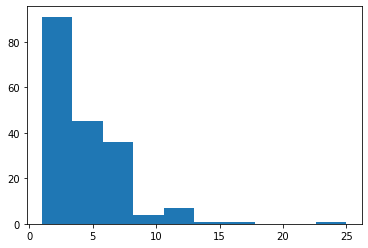

In [14]:
plt.hist(df.groupby('COUNTRY')['ID'].count().values)

# Data cleaning
Moving ahead, there are a number of features I can create there, where each one is at the grain of country/date:
- Count of total measures
- Count of measures by CATEGORY
- Count of measures by MEASURE

Of these, I like the last one, as it is the most granular. XGBoost should be able to avoid overfitting here. But maybe the first one is good too, as a sort of aggregate and very simple feature.

Issues:
- Some dates are missing. Maybe I should only count the ones that have dates? Otherwise I'd have to do some kind of imputation.
- Need to get country names aligned with Kaggle data

Then I would be ready to engineer features.

What is the null fraction of dates?

In [15]:
na_date_mask = df['DATE_IMPLEMENTED'].isnull()
print(na_date_mask.mean(), na_date_mask.sum())

0.13987730061349693 114


How would I impute these? One option is time consuming research, although if the answer were knowable presumably the researchers would have included it. Another option is to simply drop them. This is easy, however in China for example, most of the countermeasures don't have date data:

In [16]:
df[df['COUNTRY'] == 'China'][['DATE_IMPLEMENTED', 'CATEGORY', 'MEASURE', 'TARGETED_POP_GROUP', 'COMMENTS']]

,DATE_IMPLEMENTED,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS
177,NaT,Social distancing,Schools closure,NaN,SCFN's (schools for the children of foreign na...
178,NaT,Social distancing,Public services closure,NaN,NaN
179,NaT,Public health measures,Introduction of quarantine policies,Yes,all people with symptoms and in some regions t...
180,2020-01-29,Social distancing,Limit public gatherings,No,all provincial-level regions on the Chinese ma...
181,2020-03-14,Social and economic measures,Economic measures,Yes,people with low income levels
182,NaT,Public health measures,Awareness campaigns,NaN,NaN
183,NaT,Public health measures,Health screenings in airports and border cross...,Yes,International flighes
184,NaT,Social and economic measures,Emergency administrative structures activated ...,NaN,NaN
185,2020-01-27,Movement restrictions,Travel restrictions,NaN,NaN
186,NaT,Public health measures,Strengthening the public health system,NaN,"Two hospitals, namely Huoshenshan and Leishens..."


Another option is to impute in an automated way. I think a sensible way to do this would be to select a random date within the range of the first date a country has any countermeasure, and the present.

For countries where all the date data is null, this is certainly ethnocentric of me, but I will select a random date from the first U.S. countermeasure, to the present.

In [17]:
us_start_date = datetime.datetime(2020,1,31)

What is the latest date in the dataset?

In [18]:
df['DATE_IMPLEMENTED'].max()

Timestamp('2020-03-27 00:00:00')

Interesting, this is in the future. Must be a planned measure. I'll used today's date as the last date a measure can be selected from.

Just practice to prep for random imputation of dates:

In [19]:
end_date = datetime.datetime(2020, 3, 20)

In [20]:
random.seed(24)
random.choices([1, 2, 3, 4], k=3)

[3, 4, 1]

In [21]:
datetime.timedelta(days=2).days

2

https://stackoverflow.com/questions/13703720/converting-between-datetime-timestamp-and-datetime64

In [22]:
df_filled = df.copy()
random.seed(24)
for country in all_countries:
#     print('====================================')
#     print(country)
    country_mask = df['COUNTRY'] == country
#     print(df[country_mask]['DATE_IMPLEMENTED'])
    min_date_here = df[country_mask]['DATE_IMPLEMENTED'].min()
    if pd.isnull(min_date_here):
        min_date_here = us_start_date
    
    country_null_mask = country_mask & na_date_mask
    n_nulls_this_country = (country_null_mask).sum()
    if n_nulls_this_country > 0:
#         print(country)
#         print(n_nulls_this_country)
#         print(country_mask.sum())
#         print(min_date_here)
        n_days = (end_date - min_date_here).days
        days_range = list(range(1,n_days+1))
        days_choice = random.choices(days_range, k=n_nulls_this_country)
        dates_to_fill = [np.datetime64(min_date_here + datetime.timedelta(days=this_day))
                         for this_day in days_choice]
#         print(dates_to_fill)
#         print(df_filled.loc[country_null_mask, 'DATE_IMPLEMENTED'].shape)
#         print(len(dates_to_fill))
        df_filled.loc[country_null_mask, 'DATE_IMPLEMENTED'] = dates_to_fill

In [23]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  815 non-null    int64         
 1   COUNTRY             815 non-null    object        
 2   ISO                 815 non-null    object        
 3   ADMIN_LEVEL_NAME    24 non-null     object        
 4   PCODE               0 non-null      float64       
 5   REGION              815 non-null    object        
 6   CATEGORY            815 non-null    object        
 7   MEASURE             815 non-null    object        
 8   TARGETED_POP_GROUP  777 non-null    object        
 9   COMMENTS            694 non-null    object        
 10  DATE_IMPLEMENTED    815 non-null    datetime64[ns]
 11  SOURCE              797 non-null    object        
 12  SOURCE_TYPE         793 non-null    object        
 13  LINK                792 non-null    object        

In [24]:
df_filled[df_filled['COUNTRY'] == 'China']\
[['DATE_IMPLEMENTED', 'CATEGORY', 'MEASURE', 'TARGETED_POP_GROUP', 'COMMENTS']]

,DATE_IMPLEMENTED,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS
177,2020-02-09,Social distancing,Schools closure,NaN,SCFN's (schools for the children of foreign na...
178,2020-02-08,Social distancing,Public services closure,NaN,NaN
179,2020-02-22,Public health measures,Introduction of quarantine policies,Yes,all people with symptoms and in some regions t...
180,2020-01-29,Social distancing,Limit public gatherings,No,all provincial-level regions on the Chinese ma...
181,2020-03-14,Social and economic measures,Economic measures,Yes,people with low income levels
182,2020-02-12,Public health measures,Awareness campaigns,NaN,NaN
183,2020-03-14,Public health measures,Health screenings in airports and border cross...,Yes,International flighes
184,2020-03-16,Social and economic measures,Emergency administrative structures activated ...,NaN,NaN
185,2020-01-27,Movement restrictions,Travel restrictions,NaN,NaN
186,2020-02-08,Public health measures,Strengthening the public health system,NaN,"Two hospitals, namely Huoshenshan and Leishens..."


Works.

## Match up country names

In [25]:
path = '../covid19-global-forecasting-week-1/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [26]:
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In competition data set but not here

In [27]:
set(train['Country/Region'].unique()) - set(all_countries)

{'Andorra',
 'Aruba',
 'Brunei',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 "Cote d'Ivoire",
 'Cruise Ship',
 'Cuba',
 'Czechia',
 'French Guiana',
 'Gabon',
 'Gambia, The',
 'Greenland',
 'Guadeloupe',
 'Guam',
 'Guernsey',
 'Guinea',
 'Holy See',
 'Jersey',
 'Korea, South',
 'Kosovo',
 'Martinique',
 'Mayotte',
 'Moldova',
 'Monaco',
 'North Macedonia',
 'Puerto Rico',
 'Republic of the Congo',
 'Reunion',
 'Russia',
 'San Marino',
 'Taiwan*',
 'The Bahamas',
 'The Gambia',
 'US',
 'Vietnam'}

Here but not in competition:

In [28]:
set(all_countries) - set(train['Country/Region'].unique())

{'Angola',
 'Bahamas',
 'Belize',
 'Brunei Darussalam',
 'Burundi',
 'Cabo Verde',
 'Chad',
 'Comoros',
 'Congo',
 'Congo DR',
 'Czech Republic',
 "Côte d'Ivoire",
 'Dominica',
 'El Salvador',
 'Eritrea',
 'Fiji',
 'Gambia',
 'Grenada',
 'Guinea-Bissau',
 'Haiti',
 'Kiribati',
 'Korea DPR',
 'Korea Republic of',
 'Lao PDR',
 'Lesotho',
 'Libya',
 'Madagascar',
 'Malawi',
 'Mali',
 'Marshall Islands',
 'Micronesia',
 'Moldova Republic Of',
 'Mozambique',
 'Myanmar',
 'Nauru',
 'Nicaragua',
 'Niger',
 'North Macedonia Republic Of',
 'Palau',
 'Palestine',
 'Papua New Guinea',
 'Russian Federation',
 'Samoa',
 'Sierra Leone',
 'Solomon Islands',
 'South Sudan',
 'Syria',
 'Tajikistan',
 'Timor-Leste',
 'Tonga',
 'Turkmenistan',
 'Tuvalu',
 'Uganda',
 'United States of America',
 'Vanuatu',
 'Viet Nam',
 'Yemen',
 'Zimbabwe',
 'kenya'}

Unfortunately this needs to be done manually.

In [29]:
mapper = {'Bahamas':'The Bahamas',
         'Brunei Darussalam':'Brunei',
         'Congo':'Congo (Brazzaville)',
         'Congo DR':'Republic of the Congo',
         'Czech Republic':'Czechia',
         "Côte d'Ivoire":"Cote d'Ivoire",
         'Gambia':'The Gambia',
         'Guinea-Bissau':'Guinea',
         'Korea Republic of':'Korea, South',
         'Moldova Republic Of':'Moldova',
         'North Macedonia Republic Of':'North Macedonia',
         'Russian Federation':'Russia',
         'United States of America':'US',
         'Viet Nam':'Vietnam'}

Need to add elements in common to mapper.

In [30]:
intersection = set(all_countries) & set(train['Country/Region'].unique())
# intersection

In [31]:
for in_common_country in intersection:
    mapper[in_common_country] = in_common_country

In [32]:
df_countries_renamed = df_filled.copy()

In [33]:
df_countries_renamed['COUNTRY'] = df_countries_renamed['COUNTRY'].map(mapper)

In [34]:
set(train['Country/Region'].unique()) - set(df_countries_renamed['COUNTRY'].unique())

{'Andorra',
 'Aruba',
 'Congo (Kinshasa)',
 'Cruise Ship',
 'Cuba',
 'French Guiana',
 'Gabon',
 'Gambia, The',
 'Greenland',
 'Guadeloupe',
 'Guam',
 'Guernsey',
 'Holy See',
 'Jersey',
 'Kosovo',
 'Martinique',
 'Mayotte',
 'Monaco',
 'Puerto Rico',
 'Reunion',
 'San Marino',
 'Taiwan*'}

Here but not in competition:

In [35]:
set(df_countries_renamed['COUNTRY'].unique()) - set(train['Country/Region'].unique())

{nan}

If a country doesn't appear in the training set, its name is missing from this new DF. There are apparently no interventions from these countries in this data set. They can be dropped.

In [36]:
df_countries_renamed = df_countries_renamed.dropna(subset=['COUNTRY'])

Note: Probably can copy over to `'Congo (Kinshasa)'` from the other Congo. 

# Engineer features

Want a lag time from when the change was made? Perhaps the 5 day median incubation period plus a few days for the measure to take effect? That would be 7 days.

https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported:
>The median incubation period was estimated to be 5.1 days (95% CI, 4.5 to 5.8 days), and 97.5% of those who develop symptoms will do so within 11.5 days (CI, 8.2 to 15.6 days) of infection. These estimates imply that, under conservative assumptions, 101 out of every 10 000 cases (99th percentile, 482) will develop symptoms after 14 days of active monitoring or quarantine.

---

Want some kind of `DataFrame` that can be joined on country/date, with the competition data. How to do this? Perhaps a multi-index on country/date, with columns being the features.

In [37]:
df_countries_renamed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 689 entries, 0 to 814
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  689 non-null    int64         
 1   COUNTRY             689 non-null    object        
 2   ISO                 689 non-null    object        
 3   ADMIN_LEVEL_NAME    23 non-null     object        
 4   PCODE               0 non-null      float64       
 5   REGION              689 non-null    object        
 6   CATEGORY            689 non-null    object        
 7   MEASURE             689 non-null    object        
 8   TARGETED_POP_GROUP  655 non-null    object        
 9   COMMENTS            590 non-null    object        
 10  DATE_IMPLEMENTED    689 non-null    datetime64[ns]
 11  SOURCE              671 non-null    object        
 12  SOURCE_TYPE         667 non-null    object        
 13  LINK                666 non-null    object        

What is the date range of the training and testing data?

In [38]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

print(train['Date'].min())
print(train['Date'].max())
print(test['Date'].min())
print(test['Date'].max())

2020-01-22 00:00:00
2020-03-18 00:00:00
2020-03-12 00:00:00
2020-04-23 00:00:00


The features data here?

In [39]:
print(df_countries_renamed['DATE_IMPLEMENTED'].min())
print(df_countries_renamed['DATE_IMPLEMENTED'].max())
# 2020-01-02 00:00:00
# 2020-03-27 00:00:00

2020-01-02 00:00:00
2020-03-27 00:00:00


Need to build features for the complete date range of training and testing data. But some measures were implemented starting before this, so need to start earlier.

In [40]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2020, 4, 23)

In [41]:
n_days = (end_date - start_date).days + 1
n_days

114

In [42]:
all_days = [np.datetime64(start_date + datetime.timedelta(days=day_count))
            for day_count in range(n_days)]

In [43]:
print(all_days[:3])
print(all_days[-3:])
print(len(all_days))

[numpy.datetime64('2020-01-01T00:00:00.000000'), numpy.datetime64('2020-01-02T00:00:00.000000'), numpy.datetime64('2020-01-03T00:00:00.000000')]
[numpy.datetime64('2020-04-21T00:00:00.000000'), numpy.datetime64('2020-04-22T00:00:00.000000'), numpy.datetime64('2020-04-23T00:00:00.000000')]
114


In [44]:
matched_countries = df_countries_renamed['COUNTRY'].unique().tolist()
print(len(matched_countries))

141


In [45]:
matched_countries[:3]

['Afghanistan', 'Bhutan', 'Antigua and Barbuda']

In [46]:
matched_countries.sort()

In [47]:
matched_countries[:3]

['Afghanistan', 'Albania', 'Algeria']

In [48]:
list_of_tuples_for_multiindex = []
for country in matched_countries:
    for date in all_days:
        list_of_tuples_for_multiindex.append((country, date))

In [49]:
list_of_tuples_for_multiindex[:3]

[('Afghanistan', numpy.datetime64('2020-01-01T00:00:00.000000')),
 ('Afghanistan', numpy.datetime64('2020-01-02T00:00:00.000000')),
 ('Afghanistan', numpy.datetime64('2020-01-03T00:00:00.000000'))]

In [50]:
list_of_tuples_for_multiindex[-3:]

[('Zambia', numpy.datetime64('2020-04-21T00:00:00.000000')),
 ('Zambia', numpy.datetime64('2020-04-22T00:00:00.000000')),
 ('Zambia', numpy.datetime64('2020-04-23T00:00:00.000000'))]

In [51]:
index = pd.MultiIndex.from_tuples(list_of_tuples_for_multiindex, names=['COUNTRY', '7_DAY_LAG'])

In [52]:
df_features = pd.DataFrame(index=index)
df_features.head()

Empty DataFrame
Columns: []
Index: [(Afghanistan, 2020-01-01 00:00:00), (Afghanistan, 2020-01-02 00:00:00), (Afghanistan, 2020-01-03 00:00:00), (Afghanistan, 2020-01-04 00:00:00), (Afghanistan, 2020-01-05 00:00:00)]

In [53]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16074 entries, ('Afghanistan', Timestamp('2020-01-01 00:00:00')) to ('Zambia', Timestamp('2020-04-23 00:00:00'))
Empty DataFrame

https://stackoverflow.com/questions/52785579/pandas-dataframe-multiindex-merge

### Feature 1
Sum of number of days since feature implemented over all features implemented

In [54]:
df_countries_renamed['DATE_IMPLEMENTED'].head()

0   2020-02-12
1   2020-02-12
2   2020-02-12
3   2020-02-12
4   2020-03-12
Name: DATE_IMPLEMENTED, dtype: datetime64[ns]

In [55]:
df_countries_renamed['7_DAY_LAG'] = df_countries_renamed['DATE_IMPLEMENTED'] + np.timedelta64(7,'D')
df_countries_renamed['7_DAY_LAG'].head()

0   2020-02-19
1   2020-02-19
2   2020-02-19
3   2020-02-19
4   2020-03-19
Name: 7_DAY_LAG, dtype: datetime64[ns]

In [56]:
df_event_count = df_countries_renamed.groupby(['COUNTRY', '7_DAY_LAG'])['ID'].count()
df_event_count

COUNTRY      7_DAY_LAG 
Afghanistan  2020-02-08    1
             2020-02-19    4
             2020-03-02    1
             2020-03-08    4
             2020-03-19    1
                          ..
Venezuela    2020-03-22    4
             2020-03-23    2
Vietnam      2020-03-09    1
             2020-03-22    4
Zambia       2020-03-02    1
Name: ID, Length: 402, dtype: int64

In [57]:
df_feat_vals = df_features.merge(df_event_count,
                                 how='left',
                                 left_index=True,
                                 right_on=['COUNTRY', '7_DAY_LAG'])
df_feat_vals.head()

ID
COUNTRY     7_DAY_LAG     
Afghanistan 2020-01-01 NaN
            2020-01-02 NaN
            2020-01-03 NaN
            2020-01-04 NaN
            2020-01-05 NaN

In [58]:
df_feat_vals.shape

(16074, 1)

In [59]:
df_feat_vals.rename(columns={'ID':'measures_7_lag'}, inplace=True)
df_feat_vals.head()

measures_7_lag
COUNTRY     7_DAY_LAG                 
Afghanistan 2020-01-01             NaN
            2020-01-02             NaN
            2020-01-03             NaN
            2020-01-04             NaN
            2020-01-05             NaN

In [60]:
df_feat_vals['measures_7_lag'].notnull().sum()

402

In [61]:
df_feat_vals['measures_7_lag'].sum()

689.0

In [62]:
df_feat_vals['measures_7_lag'].fillna(0, inplace=True)
df_feat_vals.head()

measures_7_lag
COUNTRY     7_DAY_LAG                 
Afghanistan 2020-01-01             0.0
            2020-01-02             0.0
            2020-01-03             0.0
            2020-01-04             0.0
            2020-01-05             0.0

In [63]:
df_feat_vals['measures_all'] = 0

In [64]:
df_feat_vals.loc['Afghanistan','measures_7_lag'].cumsum()

7_DAY_LAG
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
              ... 
2020-04-19    11.0
2020-04-20    11.0
2020-04-21    11.0
2020-04-22    11.0
2020-04-23    11.0
Name: measures_7_lag, Length: 114, dtype: float64

In [65]:
for country in matched_countries:
    df_feat_vals.loc[country,'measures_all'] = df_feat_vals.loc[country,'measures_7_lag'].cumsum().values.tolist()

In [66]:
df_feat_vals.head()

measures_7_lag  measures_all
COUNTRY     7_DAY_LAG                               
Afghanistan 2020-01-01             0.0           0.0
            2020-01-02             0.0           0.0
            2020-01-03             0.0           0.0
            2020-01-04             0.0           0.0
            2020-01-05             0.0           0.0

In [67]:
df_feat_vals.loc['Afghanistan',:]

,measures_7_lag,measures_all
7_DAY_LAG,,
2020-01-01,0.0,0.0
2020-01-02,0.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
2020-01-05,0.0,0.0
...,...,...
2020-04-19,0.0,11.0
2020-04-20,0.0,11.0
2020-04-21,0.0,11.0


In [68]:
pd.set_option('display.max_rows', 150)

In [69]:
df_feat_vals.loc['China',:]

,measures_7_lag,measures_all
7_DAY_LAG,,
2020-01-01,0.0,0.0
2020-01-02,0.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
2020-01-05,0.0,0.0
2020-01-06,0.0,0.0
2020-01-07,0.0,0.0
2020-01-08,0.0,0.0
2020-01-09,0.0,0.0


Looks like this bascially worked.

Now, what I could do, is generate the same kind of features, but for types of measures individually.

I'll drop the column I used to get started here and only save the feature.

In [70]:
df_feat_vals.drop(columns=['measures_7_lag'], inplace=True)
df_feat_vals.head()

measures_all
COUNTRY     7_DAY_LAG               
Afghanistan 2020-01-01           0.0
            2020-01-02           0.0
            2020-01-03           0.0
            2020-01-04           0.0
            2020-01-05           0.0

# History of events by category

In [71]:
categories

array(['Public health measures', 'Social and economic measures',
       'Social distancing', 'Movement restrictions', 'Human rights'],
      dtype=object)

In [72]:
num = 1
for cat in categories:
    print(cat)
    
    #Mask to this category
    cat_mask = df_countries_renamed['CATEGORY'] == cat
    
    #Get a dataframe with the count of events by category, lagged 7 days
    #Fill NAs with 0 since there were no events on those days
    df_event_count_cat = df_countries_renamed[cat_mask].groupby(['COUNTRY', '7_DAY_LAG'])['ID'].count()
    df_cat_f = df_features.merge(df_event_count_cat,
                                 how='left',
                                 left_index=True,
                                 right_on=['COUNTRY', '7_DAY_LAG'])
    col_name = 'measures_7_lag_c' + str(num)
    df_cat_f.rename(columns={'ID':col_name}, inplace=True)
    df_cat_f[col_name].fillna(0, inplace=True)
    
    #Make the feature as a cumulative sum of these
    f_name = 'measures_c' + str(num)
    df_cat_f[f_name] = 0
    for country in matched_countries:
        df_cat_f.loc[country, f_name] = df_cat_f.loc[country, col_name].cumsum().values.tolist()
    
    #Join to existing feature DF
    df_cat_f.drop(columns=[col_name], inplace=True)
#     print(df_cat_f.index)
#     print(df_feat_vals.index)
    df_feat_vals = df_feat_vals.merge(df_cat_f, how='left', right_index=True, left_index=True)
#     print (df_feat_vals)
    num+=1

Public health measures
Social and economic measures
Social distancing
Movement restrictions
Human rights


In [73]:
df_feat_vals

measures_all  measures_c1  measures_c2  measures_c3  \
COUNTRY     7_DAY_LAG                                                         
Afghanistan 2020-01-01           0.0          0.0          0.0          0.0   
            2020-01-02           0.0          0.0          0.0          0.0   
            2020-01-03           0.0          0.0          0.0          0.0   
            2020-01-04           0.0          0.0          0.0          0.0   
            2020-01-05           0.0          0.0          0.0          0.0   
...                              ...          ...          ...          ...   
Zambia      2020-04-19           1.0          1.0          0.0          0.0   
            2020-04-20           1.0          1.0          0.0          0.0   
            2020-04-21           1.0          1.0          0.0          0.0   
            2020-04-22           1.0          1.0          0.0          0.0   
            2020-04-23           1.0          1.0          0.0          0.0   

                        measures_c4  measures_c5  
COUNTRY     7_DAY_LAG                             
Afghanistan 2020-01-01          0.0          0.0  
            2020-01-02          0.0          0.0  
            2020-01-03          0.0          0.0  
            2020-01-04          0.0          0.0  
            2020-01-05          0.0          0.0  
...                             ...          ...  
Zambia      2020-04-19          0.0          0.0  
            2020-04-20          0.0          0.0  
            2020-04-21          0.0          0.0  
            2020-04-22          0.0          0.0  
            2020-04-23          0.0          0.0  

[16074 rows x 6 columns]

In [74]:
df_feat_vals.loc['China',:]

,measures_all,measures_c1,measures_c2,measures_c3,measures_c4,measures_c5
7_DAY_LAG,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0


Looks like it worked. Check that `measures_all` is the sum of measures by category.

In [75]:
assert np.array_equal(df_feat_vals['measures_all'], df_feat_vals.iloc[:, 1:].sum(axis=1))

# History of events by measure

In [76]:
measures

array(['Health screenings in airports and border crossings',
       'Introduction of quarantine policies', 'Awareness campaigns',
       'Emergency administrative structures activated or established',
       'Limit public gatherings', 'Border closure\xa0',
       'Schools closure\xa0', 'Travel restrictions',
       'Strengthening the public health system', 'Flights suspension',
       'Limit product imports/exports', 'Border checks\xa0',
       'Visa restrictions', 'Checkpoints', 'Economic measures',
       'State of emergency declared',
       'Additional health/documents requirements upon arrival',
       'Public services closure\xa0',
       'Changes in prison-related policies', 'General recommendations',
       'General lockdown',
       'Psychological assistance and medical social work',
       'Obligatory medical tests not related to COVID-19',
       'Screening of all Citizens', 'Electronic surveilance',
       'Lockdown of refugee/idp camps'], dtype=object)

In [77]:
num = 1
for measure in measures:
    print(measure)
    
    #Mask to this category
    m_mask = df_countries_renamed['MEASURE'] == measure
    
    #Get a dataframe with the count of events by category, lagged 7 days
    #Fill NAs with 0 since there were no events on those days
    df_event_count_m = df_countries_renamed[m_mask].groupby(['COUNTRY', '7_DAY_LAG'])['ID'].count()
    df_meas_f = df_features.merge(df_event_count_m,
                                  how='left',
                                  left_index=True,
                                  right_on=['COUNTRY', '7_DAY_LAG'])
    col_name = 'measures_7_lag_m' + str(num)
    df_meas_f.rename(columns={'ID':col_name}, inplace=True)
    df_meas_f[col_name].fillna(0, inplace=True)
    
    #Make the feature as a cumulative sum of these
    f_name = 'measures_m' + str(num)
    df_meas_f[f_name] = 0
    for country in matched_countries:
        df_meas_f.loc[country, f_name] = df_meas_f.loc[country, col_name].cumsum().values.tolist()
    
    #Join to existing feature DF
    df_meas_f.drop(columns=[col_name], inplace=True)
#     print(df_cat_f.index.)
#     print(df_feat_vals.index)
    df_feat_vals = df_feat_vals.merge(df_meas_f, how='left', right_index=True, left_index=True)
#     print (df_feat_vals)
    num+=1

Health screenings in airports and border crossings
Introduction of quarantine policies
Awareness campaigns
Emergency administrative structures activated or established
Limit public gatherings
Border closure 
Schools closure 
Travel restrictions
Strengthening the public health system
Flights suspension
Limit product imports/exports
Border checks 
Visa restrictions
Checkpoints
Economic measures
State of emergency declared
Additional health/documents requirements upon arrival
Public services closure 
Changes in prison-related policies
General recommendations
General lockdown
Psychological assistance and medical social work
Obligatory medical tests not related to COVID-19
Screening of all Citizens
Electronic surveilance
Lockdown of refugee/idp camps


In [78]:
df_feat_vals.loc['China',:]

,measures_all,measures_c1,measures_c2,measures_c3,measures_c4,measures_c5,measures_m1,measures_m2,measures_m3,measures_m4,...,measures_m17,measures_m18,measures_m19,measures_m20,measures_m21,measures_m22,measures_m23,measures_m24,measures_m25,measures_m26
7_DAY_LAG,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check sum for measures

In [79]:
assert np.array_equal(df_feat_vals['measures_all'], df_feat_vals.iloc[:, 6:].sum(axis=1))

Works

In [80]:
df_feat_vals.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16074 entries, ('Afghanistan', Timestamp('2020-01-01 00:00:00')) to ('Zambia', Timestamp('2020-04-23 00:00:00'))
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   measures_all  16074 non-null  float64
 1   measures_c1   16074 non-null  float64
 2   measures_c2   16074 non-null  float64
 3   measures_c3   16074 non-null  float64
 4   measures_c4   16074 non-null  float64
 5   measures_c5   16074 non-null  float64
 6   measures_m1   16074 non-null  float64
 7   measures_m2   16074 non-null  float64
 8   measures_m3   16074 non-null  float64
 9   measures_m4   16074 non-null  float64
 10  measures_m5   16074 non-null  float64
 11  measures_m6   16074 non-null  float64
 12  measures_m7   16074 non-null  float64
 13  measures_m8   16074 non-null  float64
 14  measures_m9   16074 non-null  float64
 15  measures_m10  16074 non-null  float64
 16  measures_m11  16074 non-n

In [81]:
df_feat_vals.to_csv('../data/measures_features_3_24_20.csv', index=True)

Maybe: Some kind of measure of how compliant citizenry is? Measures only work if people pay attention. Not sure where to get this though.